# Problem Set #2: Drift-diffusion Model
**DUE 5 April 2022 - NEU 502A**

**Submission Directions:** Prior to submitting, clear you kernel and run through all your cells in order so figures and variables are accurately recorded. Only include cells with necessary code or answers, do not include cells used for troubleshooting. Email this notebook with your last name in the filename to Eric (ewh3@princeton.edu) by 5pm.

As mentioned in class, the drift-diffusion model has been a dominant model in understanding how decisions are made. The model predicts how one makes a decision by integrating evidence over time. Part of the power of the drift-diffusion model is how simple it is. The dynamics are captured by:
$$ dC = v \cdot dt + w \cdot \mathcal{N}(0,1) $$
Where $C$ is your decision variable, $v$ is the evidence that one is accumulating (the ‘drift’), and $w$ is the amount of noise in the integration (the ‘diffusion’). The initial condition is typically set to $C_0$ = 0 and the integration occurs to some bound +/- $B$, which initiates the choice. To get a better intuition for how the model works, let’s simulate a decision process using the drift-diffusion model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st
from statannot import add_stat_annotation


%matplotlib inline
sns.set_context('talk')

In [2]:
c = 0 #decision variable
v = 2.5 # evidence
dt = .0005 #time step 
w = 0.05 # noise weight
B = 1 # bound

**1. Simulate a simple decision process using the drift-diffusion model.** Parameters should be $C_0$ = 0, $B$ = 1, $dt$ = 0.0005 sec, $v$ = 2.5, and $w$ = 0.05. Run at least 1000 simulations to get a good sense of how the model behaves.

In [3]:
def dynamics(c, v, dt, w, B):
    '''
    To simultate the drift diffusion-to-bound model:

    INPUTS
    .  c: scalar, descision variable
    .  v: scalar, drift rate
    . dt: scalar, time step (in seconds)
    .  w: scalar, drift noise
    .  B: scalar, boundary
      
    OUTPUTS
    . c: int, decision [lb = -1, ub = 1]
    . z: scalar, reaction time (in sec)
    . x: array, accumlated evidence 
    '''
    
    C = []
    while np.abs(c) < B:                     #while the decision variable is within the decision boundary 
        c = c + v*dt + w*np.random.randn()   #update C, given the provided equation
        C.append(c)
        
    return np.array(C), np.sign(c)


1a ::: Plot a few (~10) model runs for both ‘correct’ and ‘incorrect’ trials. Briefly explain why the model occasionally makes decision errors.

In [4]:
seed = 0
colors = [plt.cm.Dark2(x) for x in range(10) ]
n_sims = 1000
np.random.seed(seed) #use random.seed to keep values consistent

sim_data = []

for _ in range(n_sims):
    simulation_i = dynamics(c, v, dt, w, B)
    sim_data.append(simulation_i)
    
decisions = [sim_data_i[1] for sim_data_i in sim_data]
decisions_drift = [sim_data_i[0] for sim_data_i in sim_data]
decision_time = [len(sim_data_i[0]) for sim_data_i in sim_data]

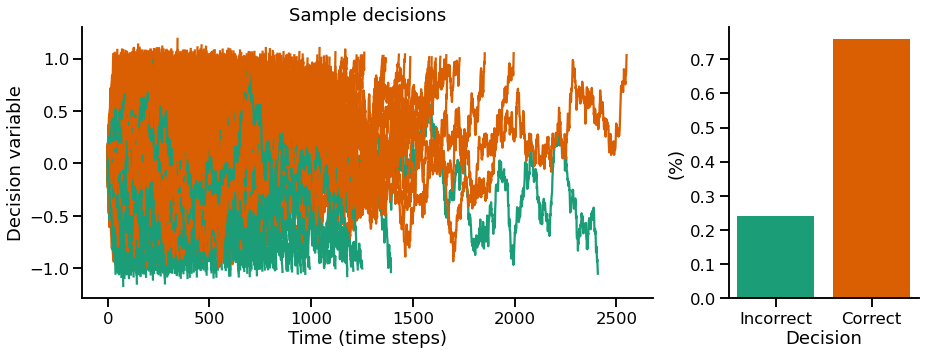

In [5]:
fig, axes = plt.subplots(1,2, figsize=(15,5), 
                         gridspec_kw={'width_ratios': [3, 1]})

for decision_drift, decision in zip(decisions_drift, decisions):
    axes[0].plot(decision_drift, color = colors[int(decision>0)])

axes[0].set_title('Sample decisions')
axes[0].set_xlabel('Time (time steps)')
axes[0].set_ylabel('Decision variable')

axes[1].bar(['Incorrect','Correct'], [np.sum(np.array(decisions)==-1)/n_sims, 
                     np.sum(np.array(decisions)==1)/n_sims], color=colors[:2])
axes[1].set_xlabel('Decision')
axes[1].set_ylabel('(%)')

sns.despine()
plt.show()

> **Answer:** Evidence accumulation is a stochastic & noisy process. Given the chosen parameters the diffusion ($w \cdot \mathcal{N}(0,1)$) may be large enough to allow for 'incorrect' responses despite initial biasing evidence ($v \cdot dt$). See the full model below.

$$ dC = v \cdot dt + w \cdot \mathcal{N}(0,1) $$

1b ::: Plot the percentage of runs that ended in ‘correct’ and ‘incorrect’ choices.

In [6]:
#see above


1c ::: Plot the reaction time distribution for ‘correct’ and ‘incorrect’ trials separately. Describe the shape of the reaction time distribution (e.g. what is the mean? the median? Is it symmetric or skewed?). Relate the shape of the reaction time distribution to human/animal behavioral responses.

In [7]:
df = pd.DataFrame(np.vstack([decisions_drift, 
                                         decisions, 
                                    decision_time, 
                             np.zeros_like(decisions)]).T, 
                      columns=('Drift','Decision','Time', 'Condition'))


df.Decision = df.Decision.replace({-1:'Incorrect', 1:'Correct'})
df.Condition = df.Condition.replace({0:'baseline'})

df.Time = df.Time.astype(float) 


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

baseline_Correct v.s. baseline_Incorrect: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.757e-01 U_stat=9.598e+04


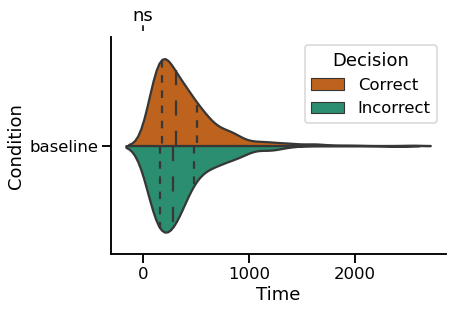

In [8]:


g = sns.violinplot(data=df, x='Time', y='Condition', orient="h",
                    hue ='Decision',   split=True, inner="quart",
                  palette= {'Incorrect': colors[0], 'Correct': colors[1]})


add_stat_annotation(g, data=df, x='Time', y='Condition', hue ='Decision', 
                    box_pairs=[(('baseline', 'Correct'), ('baseline', 'Incorrect'))],
                    test='Mann-Whitney', text_format='star', 
                    loc='outside', verbose=2)

sns.despine()   
plt.show(g)
## The Mann-Whitney U test is the nonparametric equivalent of the two sample t-test

In [9]:
df.groupby('Decision')['Time'].agg(['count','mean','median','min', 'max']) 

,count,mean,median,min,max
Decision,,,,,
Correct,758,391.013193,308.0,28.0,2551.0
Incorrect,242,371.128099,286.5,39.0,2410.0


>**Answer:** The reaction times are skewed right, i.e, the majority of them are withing very low values with some larger outliers. This skeweness is charactrized by larger mean than median. See table above for full summary statistics. Notice, that both distribution behave similarly regardless of the smaller amount of incorrect responses.

> This right-tailed distribution could be realted to (a) this being a non negative distribution: i.e response time can not be smaller than 0. However, there is no limit on its larger values. and (b) While learning and motivation can explain lower reaction time values, it is efortfull. Lack of it/lack of attention could explain large reaction times. Also (c) usually these paradigms have no upper bound enforced on them.

**2. If sensory evidence is increased (2x) or decreased (0.5x), how does this impact the decision process in the drift-diffusion model?**

2a ::: Describe how you modeled a change in the sensory evidence.

> **Answer:** We model changes in sensory evideince via manipulating the drift rate ($v$). Higher $v$ is expected to increase the contribution of the drift relative to the diffusion, lowering the stochastic effect (and vice versa). In addition, in this case, we expect the bound to be met faster - thus yielding faster decisions.

> The plots below confirm this intuition. Weak evidence (top) yields higher than baseline (middle) incorrect decisions & takes longer. Strong evidence (bottom) yields lower than baseline (middle) incorrect decisions & takes shorter.

2b ::: As for 1a, plot a few model runs, the percent of correct/incorrect, and the reaction time distributions for all three levels of sensory evidence (baseline, increased, and decreased).

In [10]:
seed=0
np.random.seed(seed) #use random.seed to keep values consistent

v_strong = v*2
v_weak = v/2

v_conditions = [v_weak, v, v_strong]
all_decisions_v = []
all_decisions_drifts_v = []

all_conditions_v = []
all_decisions_times_v = []

for v_cond, condition in zip(v_conditions, ['weak', 'baseline', 'strong']):
    for _ in range(n_sims):
        simulation_i = dynamics(c, v_cond, dt, w, B)
        all_decisions_v.append(simulation_i[1])
        all_conditions_v.append(condition)
        all_decisions_times_v.append(len(simulation_i[0]))
        all_decisions_drifts_v.append(simulation_i[0])

In [75]:
df_all_v = pd.DataFrame(np.vstack([all_decisions_drifts_v, all_decisions_v, 
                                   all_decisions_times_v, 
                                  all_conditions_v]).T, 
                      columns=('Drift','Decision','Time','Condition'))

df_all_v.Time = df_all_v.Time.astype(float) 
df_all_v.Decision = df_all_v.Decision.replace({-1:'Incorrect', 1:'Correct'})


In [76]:
df_all_v.head()

,Drift,Decision,Time,Condition
0,"[0.0888276172983832, 0.10946047771674437, 0.15...",Correct,130.0,weak
1,"[-0.037870803722265825, -0.01028334415767496, ...",Incorrect,227.0,weak
2,"[-0.023273700202024336, -0.04663149090242172, ...",Incorrect,233.0,weak
3,"[0.027790594569375986, 0.05036774245297811, 0....",Incorrect,188.0,weak
4,"[-0.08099616510339917, -0.08372787283412526, -...",Correct,341.0,weak


In [77]:
weak_data = df_all_v[(df_all_v.Condition=='weak')]
strong_data = df_all_v[(df_all_v.Condition=='strong')]
baseline_data = df_all_v[(df_all_v.Condition=='baseline')]

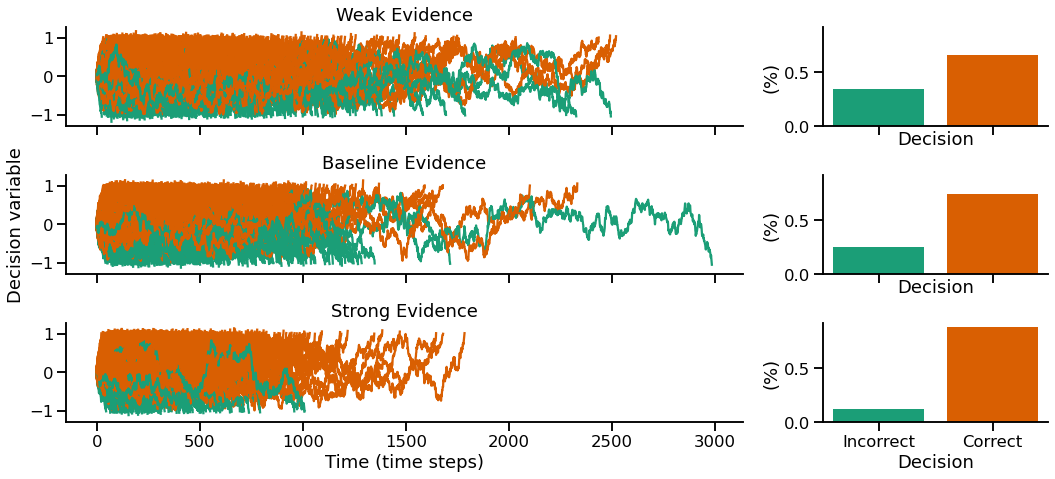

In [83]:
fig, axes = plt.subplots(3,2, figsize=(15,7), sharex='col', sharey='col',
                         gridspec_kw={'width_ratios': [3, 1]})

axes[0][0].set_title('Weak Evidence')
axes[1][0].set_title('Baseline Evidence')
axes[2][0].set_title('Strong Evidence')


for d in weak_data.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[0][0].plot(d_drift, color = colors[int(d_decision=='Correct')])

# axes[0][0].set_xlabel('Time (time steps)')
# axes[0][0].set_ylabel('Decision variable')


axes[0][1].bar(['Incorrect','Correct'], [np.sum(np.array(weak_data.Decision)=='Incorrect')/n_sims, 
                     np.sum(np.array(weak_data.Decision)=='Correct')/n_sims], color=colors[:2])
axes[0][1].set_xlabel('Decision')
axes[0][1].set_ylabel('(%)')


for d in baseline_data.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[1][0].plot(d_drift, color = colors[int(d_decision=='Correct')])

#axes[1][0].set_xlabel('Time (time steps)')
axes[1][0].set_ylabel('Decision variable')


axes[1][1].bar(['Incorrect','Correct'], [np.sum(np.array(baseline_data.Decision)=='Incorrect')/n_sims, 
                     np.sum(np.array(baseline_data.Decision)=='Correct')/n_sims], color=colors[:2])
axes[1][1].set_xlabel('Decision')
axes[1][1].set_ylabel('(%)')

for d in strong_data.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[2][0].plot(d_drift, color = colors[int(d_decision=='Correct')])

axes[2][0].set_xlabel('Time (time steps)')
#axes[2][0].set_ylabel('Decision variable')


axes[2][1].bar(['Incorrect','Correct'], [np.sum(np.array(strong_data.Decision)=='Incorrect')/n_sims, 
                     np.sum(np.array(strong_data.Decision)=='Correct')/n_sims], color=colors[:2])
axes[2][1].set_xlabel('Decision')
axes[2][1].set_ylabel('(%)')

sns.despine()
plt.tight_layout()
plt.show()

**3. Subjects appear to be able to trade accuracy for speed in most perceptual decision making tasks. The drift-diffusion model can capture this tradeoff in a simple manner.**

3a ::: Describe how you modeled the accuracy/speed tradeoff. Why is this a biologically plausible way of capturing this effect?

> **Answer:** We model accuracy via the boundary parameter $B$, which reflects decision threshold. Smaller boundary asks for less evidence before reaching a decision, and larger one asks for more. Lower boundary is likely to result in faster decision, but may include more noise (and vice versa)

> Biologically, we can analogize this to go/no-go dopaniergic activity. While one group of neurons (D1) increases the likelihood of response, another group (D2) inhibits it. The STN hypothesis, referring to the cortical SubThalamic Nucleus networks, claims that a decrease in STN activity reduces inhibition and result in responses that are fast but error-prone. 

> The plots below demonstrate the accuracy/speed trade-off, showing that larger boundaries indeed increase accuracy but also yield larger reaction times (and vise versa).

3b ::: Again, as in 1a, plot a few model runs, the percent of correct/incorrect, and the reaction time distributions for your baseline model, an ‘accurate’ biased model, and a ‘speed’ biased model.

In [15]:
np.random.seed(seed)# use random.seed to keep values consistent


b_speed = B -.5
b_accurate = B +.5

b_conditions = [b_speed, B, b_accurate]
all_decisions_b = []
all_decisions_drifts_b = []

all_conditions_b = []
all_decisions_times_b = []

for b_cond, condition in zip(b_conditions, ['speed', 'baseline', 'accurate']):
    for _ in range(n_sims):
        simulation_i = dynamics(c, v, dt, w, b_cond)
        all_decisions_b.append(simulation_i[1])
        all_conditions_b.append(condition)
        all_decisions_times_b.append(len(simulation_i[0]))
        all_decisions_drifts_b.append(simulation_i[0])

In [16]:
df_all_b = pd.DataFrame(np.vstack([all_decisions_drifts_b, 
                                   all_decisions_b, 
                                   all_decisions_times_b, 
                                  all_conditions_b]).T, 
                      columns=('Drift','Decision','Time', 'Condition'))


In [17]:
speed_data = df_all_b[(df_all_b.Condition=='speed')]
accurate_data = df_all_b[(df_all_b.Condition=='accurate')]
baseline_data = df_all_b[(df_all_b.Condition=='baseline')]

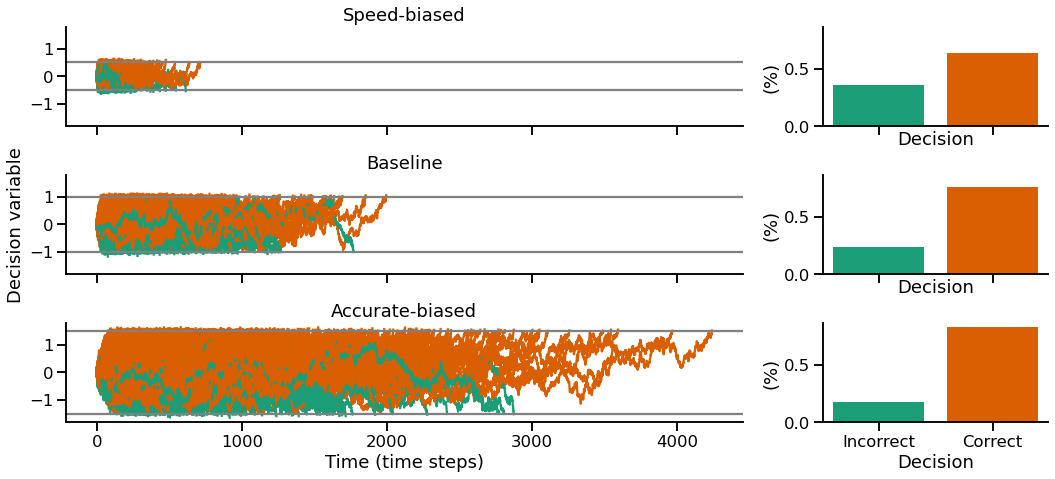

In [18]:
fig, axes = plt.subplots(3,2, figsize=(15,7), sharex='col', sharey='col',
                         gridspec_kw={'width_ratios': [3, 1]})

axes[0][0].set_title('Speed-biased')
axes[1][0].set_title('Baseline')
axes[2][0].set_title('Accurate-biased')


for d in speed_data.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[0][0].plot(d_drift, color = colors[int(d_decision>0)])

# axes[0][0].set_xlabel('Time (time steps)')
# axes[0][0].set_ylabel('Decision variable')

axes[0][0].axhline(y=.5, color='grey')
axes[0][0].axhline(y=-.5, color='grey')

axes[0][1].bar(['Incorrect','Correct'], [np.sum(np.array(speed_data.Decision)==-1)/n_sims, 
                     np.sum(np.array(speed_data.Decision)==1)/n_sims], color=colors[:2])
axes[0][1].set_xlabel('Decision')
axes[0][1].set_ylabel('(%)')


for d in baseline_data.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[1][0].plot(d_drift, color = colors[int(d_decision>0)])

#axes[1][0].set_xlabel('Time (time steps)')
axes[1][0].set_ylabel('Decision variable')
axes[1][0].axhline(y=1, color='grey')
axes[1][0].axhline(y=-1, color='grey')

axes[1][1].bar(['Incorrect','Correct'], [np.sum(np.array(baseline_data.Decision)==-1)/n_sims, 
                     np.sum(np.array(baseline_data.Decision)==1)/n_sims], color=colors[:2])
axes[1][1].set_xlabel('Decision')
axes[1][1].set_ylabel('(%)')

for d in accurate_data.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[2][0].plot(d_drift, color = colors[int(d_decision>0)])

axes[2][0].set_xlabel('Time (time steps)')
#axes[2][0].set_ylabel('Decision variable')
axes[2][0].axhline(y=1.5, color='grey')
axes[2][0].axhline(y=-1.5, color='grey')

axes[2][1].bar(['Incorrect','Correct'], [np.sum(np.array(accurate_data.Decision)==-1)/n_sims, 
                     np.sum(np.array(accurate_data.Decision)==1)/n_sims], color=colors[:2])
axes[2][1].set_xlabel('Decision')
axes[2][1].set_ylabel('(%)')

sns.despine()

plt.tight_layout()
plt.show()

**4. Using the original ‘baseline’ model, if you examine the reaction time distributions for correct and error trials you’ll notice that they are overlapping. However, in experiments, reaction times for incorrect trials are typically longer than for correct trials.** To capture this effect, let’s add some more variability across trials. Instead of a fixed $v$ for all trials, allow $v$ to vary across trials according to a normal distribution: $v$ = 2.5 + $N$(0, 2.5).

4a ::: Plot the reaction time distributions for both correct and incorrect trials. Describe the distributions as in 1a. Does this better capture experimental observations?

In [68]:
np.random.seed(seed)# use random.seed to keep values consistent

get_v_stochastic = lambda: st.norm(v, 3.5).rvs()


# v_stoch_conditions = [v, None]
all_decisions_v_stoch = []
all_decisions_drifts_v_stoch = []

all_conditions_v_stoch = []
all_decisions_times_v_stoch = []

# for v_cond, condition in zip(v_stoch_conditions, ['baseline', 'stochastic']):
for _ in range(n_sims):
    v_s = get_v_stochastic()

    simulation_i = dynamics(c, v_s, dt, w, B)
    all_decisions_v_stoch.append(simulation_i[1])
    all_conditions_v_stoch.append('stochastic')
    all_decisions_times_v_stoch.append(len(simulation_i[0]))
    all_decisions_drifts_v_stoch.append(simulation_i[0])

In [69]:
df_v_stoch = pd.DataFrame(np.vstack([all_decisions_drifts_v_stoch, 
                                         all_decisions_v_stoch, 
                                    all_decisions_times_v_stoch, 
                                 all_conditions_v_stoch]).T, 
                      columns=('Drift','Decision','Time', 'Condition'))

df_v_stoch.Time = df_v_stoch.Time.astype(float) 
df_v_stoch.Decision = df_v_stoch.Decision.replace({-1:'Incorrect', 1:'Correct'})


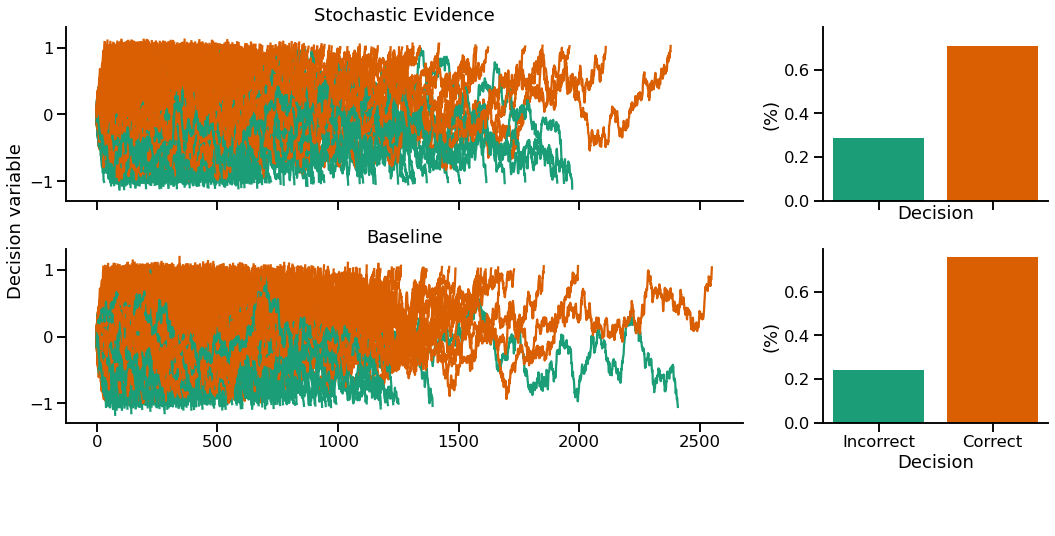

In [70]:
fig, axes = plt.subplots(2,2, figsize=(15,7), sharex='col', sharey='col',
                         gridspec_kw={'width_ratios': [3, 1]})

axes[0][0].set_title('Stochastic Evidence')
axes[1][0].set_title('Baseline')


for d in df_v_stoch.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[0][0].plot(d_drift, color = colors[int(d_decision=='Correct')])

# axes[0][0].set_xlabel('Time (time steps)')
# axes[0][0].set_ylabel('Decision variable')


axes[0][1].bar(['Incorrect','Correct'], [np.sum(np.array(df_v_stoch.Decision)=='Incorrect')/n_sims, 
                     np.sum(np.array(df_v_stoch.Decision)=='Correct')/n_sims], color=colors[:2])
axes[0][1].set_xlabel('Decision')
axes[0][1].set_ylabel('(%)')


for d in df.iterrows():
    d_drift = d[1].Drift
    d_decision = d[1].Decision
    axes[1][0].plot(d_drift, color = colors[int(d_decision=='Correct')])

#axes[1][0].set_xlabel('Time (time steps)')
axes[1][0].set_ylabel('                                        Decision variable')


axes[1][1].bar(['Incorrect','Correct'], [np.sum(np.array(df.Decision)=='Incorrect')/n_sims, 
                     np.sum(np.array(df.Decision)=='Correct')/n_sims], color=colors[:2])
axes[1][1].set_xlabel('Decision')
axes[1][1].set_ylabel('(%)')


sns.despine()

plt.tight_layout()
plt.show()

In [71]:
df_baseline_stoch = pd.concat([df, df_v_stoch], ignore_index=True)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

stochastic_Correct v.s. stochastic_Incorrect: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.881e-03 U_stat=9.109e+04


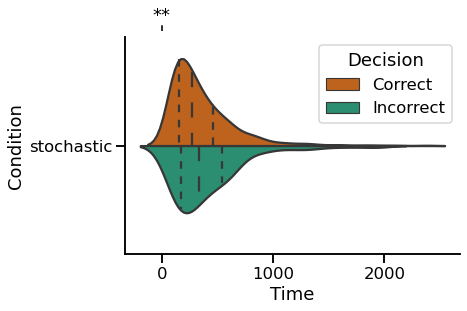

In [72]:
from statannot import add_stat_annotation

ax = sns.violinplot(data=df_v_stoch, 
                 x='Time', y='Condition', orient="h",
                     hue ='Decision',   split=True, inner="quart",
                  palette= {'Incorrect': colors[0], 'Correct': colors[1]})


add_stat_annotation(ax, data=df_v_stoch, x='Time', y='Condition', hue ='Decision',
                    box_pairs=[(('stochastic', 'Correct'),('stochastic', 'Incorrect'))],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

sns.despine()   
plt.show(g)

In [73]:
df_baseline_stoch.groupby(['Condition','Decision'])['Time'].agg(['count','mean','median','min', 'max']) 


count        mean  median   min     max
Condition  Decision                                          
baseline   Correct      758  391.013193   308.0  28.0  2551.0
           Incorrect    242  371.128099   286.5  39.0  2410.0
stochastic Correct      711  357.129395   274.0  33.0  2380.0
           Incorrect    289  419.401384   331.0  31.0  1972.0

> **Answer:** The baseline model fails to capture the longer RT in incorrect answers (see statistics above). Using a stochastic drift rate (here $v \sim N(2.5,3.5)$) enables to simulate data where the RT of incorrect choice is significantly larger than this of correct choices. 
*The Mann–Whitney U test is appropriate since it is a nonparametric t-test (suitable for skewed or of different sizes independent populations). 

** $v \sim N(2.5,2.5)$ did not generate varied enough drifts, so i used $\sigma=3.5$ instead.


4b ::: Provide an intuitive explanation for why there is now an increase in reaction time for error trials. Is this biologically plausible?

> **Answer:** Trial-to-trial variability in drift rate yields slow incorrect choices (relative to correct ones) because trials with randomly higher drift rates have fast responses but very few errors. Whereas trials with randomly lower drift rates are likely to slow responses, many of which are also incorrect. This asymmetry (fast errors with low probability and slow errors with higher probability) results in slower errors, on average. 

> **Answer:** This variability need not be random. Systematic variability could then be explained via context or bias - manifesting a top-down effect on decision making. Fluctuations in arousal, motivation, satiety, or fatigue could also explain variation in drift rate.

#### some resources 

Ratcliff, R., Smith, P. L., Brown, S. D., & McKoon, G. (2016). Diffusion Decision Model: Current Issues and History. Trends in cognitive sciences, 20(4), 260–281. https://doi.org/10.1016/j.tics.2016.01.007

Nguyen, Q. N., & Reinagel, P. (2022). Different forms of variability could explain a difference between human and rat decision making. Frontiers in neuroscience, 16.
____ 

Ratcliff, R., & McKoon, G. (2008). The diffusion decision model: theory and data for two-choice decision tasks. Neural computation, 20(4), 873-922.

Ratcliff, R., & Rouder, J. N. (1998). Modeling Response Times for Two-Choice Decisions. Psychological Science, 9(5), 347–356. doi:10.1111/1467-9280.00067 

Gupta, A., Bansal, R., Alashwal, H., Kacar, A. S., Balci, F., & Moustafa, A. A. (2021). Neural Substrates of the Drift-Diffusion Model in Brain Disorders. Frontiers in Computational Neuroscience, 15.
